<a href="https://www.kaggle.com/desmondrn/morebikes-peter-s-models-comparison?scriptVersionId=84845066" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reset -f

In [2]:
%%capture

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor

import joblib

import tensorflow as tf
mae = tf.keras.losses.MeanAbsoluteError()    ## The loss for this task
_ = mae([1], [2]) 

import os

INPUT_DIR = '/kaggle/input/morebikes2021'
ASSETS_DIR = '/kaggle/input/motorbikes-all-stations-training-comparison'

FEATURE_SET = 'short_full_temp'   ## Change here to use different features


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

# Objective

This notebook deals with Phases 2 and 3 of the Kaggle competition. It build on the results from the previous notebook (Phase 1) to compare our models with the 200 pre-trained linear models that are provided (hereafter known as Peter's models). After that, we combined those models' predictions with ours, hence reusing the knowledge learned from a whole year's data, and knowledge from appropriate stations.

*In order to change our models and obtain different results in this notebook, one should edit and save the previous notebook `MoreBikes - All-Stations Training & Comparison` before reruning this one.*

In [3]:
def get_peters_features():
    short = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes']
    short_temp = short + ['temperature.C']
    full = ['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    full_temp = full + ['temperature.C']
    short_full = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    short_full_temp = short_full + ['temperature.C']
    
    if FEATURE_SET=='short':
        return short
    elif FEATURE_SET=='short_temp':
        return short_temp
    elif FEATURE_SET=='full':
        return full
    elif FEATURE_SET=='full_temp':
        return full_temp
    elif FEATURE_SET=='short_full':
        return short_full
    elif FEATURE_SET=='short_full_temp':
        return short_full_temp
    
features_to_use = get_peters_features()

# Load and use Peter's 200 models

Once we loaded the models and made 200 different predictions for every instance in the validation set, we had two options for settling on a single prediction:
1. By averaging all the predictions,
2. By picking the most voted prediction.

We implemented both strategies. We will see in charts below that these two "bagging" approaches returned similar results.

In [4]:
## Test to see what a model on station #15 looks like
# os.listdir(models_path)
filename = INPUT_DIR+'/Models/Models/model_station_15_rlm_'+FEATURE_SET+'.csv'
df = pd.read_csv(filename)
df

,feature,weight
0,(Intercept),0.474165
1,bikes_3h_ago,0.722575
2,short_profile_bikes,0.087626
3,short_profile_3h_diff_bikes,0.183965
4,full_profile_bikes,0.080852
5,full_profile_3h_diff_bikes,0.379289
6,temperature.C,0.001965


In [5]:
def make_model_path(station_id):
    return INPUT_DIR+'/Models/Models/model_station_'+str(station_id)+'_rlm_'+FEATURE_SET+'.csv'

def predict_with_peters_model(model, X):
    
    ## Get the weigths in correct order (intercept first)
    df = model.set_index('feature')
    new_feats = ['(Intercept)'] + features_to_use
    df = df.reindex(new_feats)
    
    weights = np.array(df['weight'])
    
    return weights @ X.T

In [6]:
## Load validation data
X_val = np.load(ASSETS_DIR+'/X_val.npy')
y_val = np.load(ASSETS_DIR+'/y_val.npy')

X_val.shape

(2175, 6)

In [7]:
## Add intercept before making predictions
intercept = np.ones((len(X_val)))[:, np.newaxis]

X_val_intercept = np.concatenate([intercept, X_val], axis=1)
X_val_intercept.shape

(2175, 7)

In [8]:
peters_full_preds = np.zeros((len(X_val), 200))

for model_id in range(1, 201):
    model = pd.read_csv(make_model_path(model_id))
    
    preds = predict_with_peters_model(model, X_val_intercept)
    peters_full_preds[:, model_id-1] = preds
    
# print(peters_full_preds)
peters_full_preds = np.rint(peters_full_preds)

## Average predictions

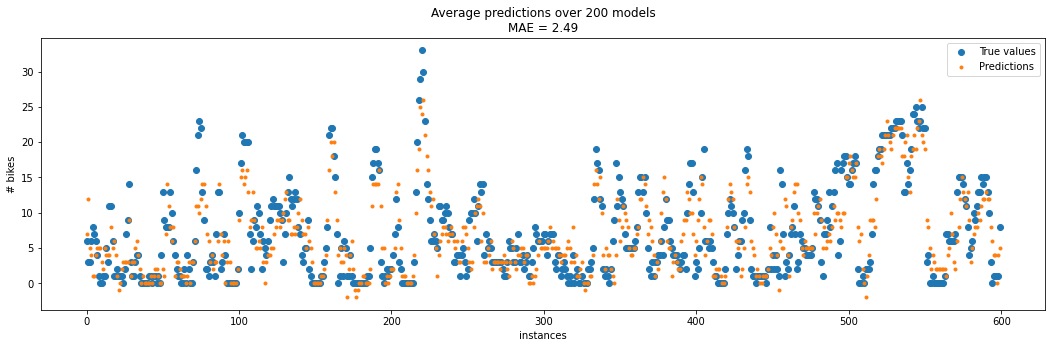

In [9]:
def plot_results(y_pred, title):
    fig, ax = plt.subplots(1, 1, figsize=(18, 5))

    plt.plot(y_val[:600], "o", label="True values")
    ax.plot(y_pred[:600], ".", label="Predictions")
    ax.set_xlabel("instances")
    ax.set_ylabel("# bikes")
    ax.legend(loc="best")
    ax.set_title(
        title+"\nMAE = {:.2f}".format(
            mae(y_val, y_pred).numpy()
        )
    )
    
peters_avg_preds = np.rint(np.mean(peters_full_preds, axis=1))

plot_results(peters_avg_preds, 'Average predictions over 200 models')

## Voting predictions

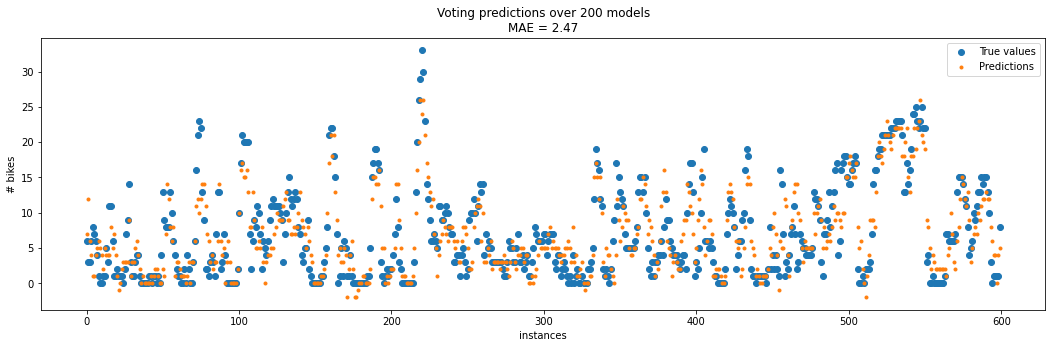

In [10]:
## Returns the most-voted index in a single 1-dimensional array
def vote(pred):
    uniques = np.unique(pred)
    counts = np.zeros_like(uniques)
    
    for j in range(len(uniques)):
        counts[j] = (pred==uniques[j]).sum()
    
    return uniques[np.argmax(counts)]

## Votes on a batch of data 
def get_voting_preds(full_preds):
    voting_preds = np.zeros((len(full_preds)))

    for i in range(len(full_preds)):
        voting_preds[i] = vote(np.rint(full_preds[i]))
        
    return voting_preds

peters_voting_preds = get_voting_preds(peters_full_preds)

plot_results(peters_voting_preds, 'Voting predictions over 200 models')
# peters_voting_preds

# Compare to our results in the previous notebook

Here we load, repeat and diplay the results we obtained in the previous notebook (Phase 1). 

## All stations together

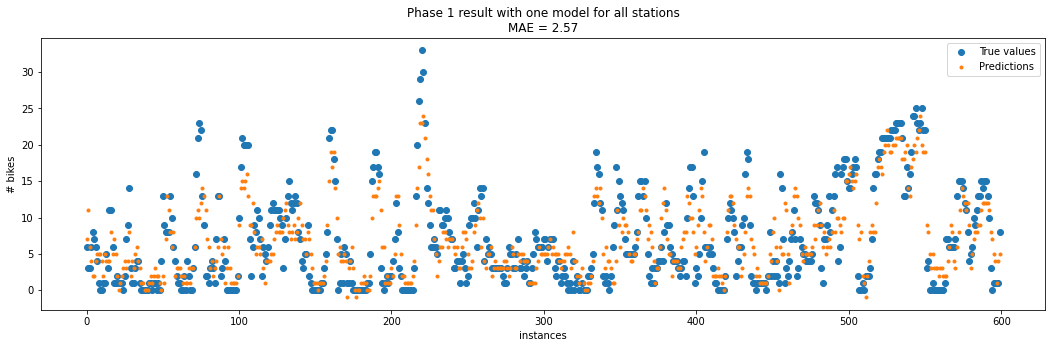

In [11]:
all_stations_model = joblib.load(ASSETS_DIR+'/all_stations_model.pkl')

all_stations_preds = np.rint(all_stations_model.predict(X_val))

plot_results(all_stations_preds, 'Phase 1 result with one model for all stations')

## One model per station

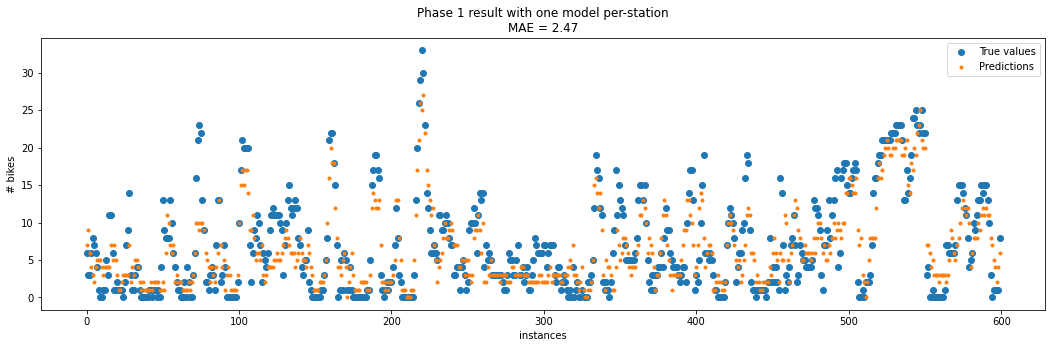

In [12]:
per_station_models = joblib.load(ASSETS_DIR+'/per_station_models.pkl')
stations = np.load(ASSETS_DIR+'/stations_val.npy')

per_station_preds = np.zeros_like(y_val)
for i in range(len(y_val)):
    per_station_preds[i] = np.rint(per_station_models[stations[i]].predict([X_val[i]]))

plot_results(per_station_preds, 'Phase 1 result with one model per-station')

# Combining all models 

Here, we combine our predictions to those from the 200 linear models by means of averaging and voting. For each instance, we will find the weight our prediction should be assigned in order to minimize the combined MAE. Once the (optimal) weight is known, we duplicate our prediction by $dupcount = \frac{200 \times weight}{ 1 - weight}$ before combining to the others, then averaging or voting just as we've done so far. 

## Peter's predictions with our per-station predictions - **Averaging**

In [13]:
def combine_with_peters(our_preds, our_weight):
    dup_count = int(200*our_weight / (1-our_weight))
    weighted_preds = np.tile(our_preds[:, np.newaxis], reps=(1, dup_count))

    return np.concatenate([peters_full_preds, weighted_preds], axis=1)

## Plot evolution of scores with weights
def plot_score_evolution(x, y, title):
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))

    plt.plot(x, y, "g-")
    argmin = np.argmin(y)
    print("Min MAE score:", x[argmin], y[argmin])
    plt.plot(x[argmin], y[argmin], "ro", label="Min score = "+str(np.round(y[argmin],2)))
    ax.set_xlabel("weight")
    ax.set_ylabel("MAE score")
    ax.legend(loc="best")
    ax.set_title(title)
    
    return x[argmin]

Min MAE score: 0.38606060606060605 2.420229911804199


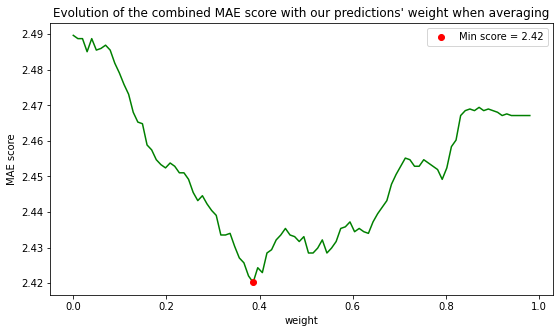

In [14]:
x = np.linspace(0, 0.98, 100)
y = np.zeros_like(x)
for i in range(len(x)):
    full_full_preds = combine_with_peters(per_station_preds, x[i])
    resulting_preds = np.rint(np.mean(full_full_preds, axis=1))
    y[i] = mae(y_val, resulting_preds)

best_weigth1 = plot_score_evolution(x, y, title="Evolution of the combined MAE score with our predictions' weight when averaging")

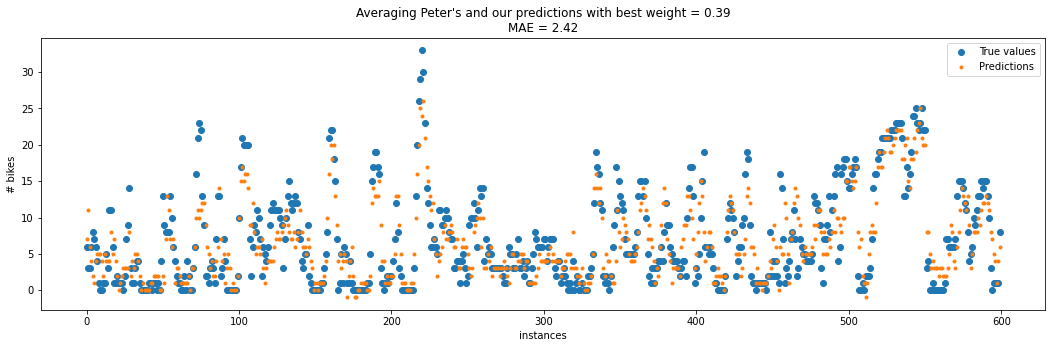

In [15]:
our_weigth = best_weigth1 
full_full_preds = combine_with_peters(per_station_preds, our_weigth)
# print(full_full_preds.shape)

resulting_preds = np.rint(np.mean(full_full_preds, axis=1))

plot_results(resulting_preds, "Averaging Peter's and our predictions with best weight = "+str(np.round(our_weigth,2)))

## Peter's predictions with our per-station predictions - **Voting**

Min MAE score: 0.32666666666666666 2.426666736602783


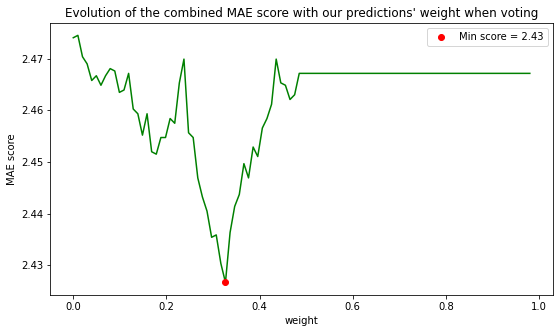

In [16]:
x = np.linspace(0, 0.98, 100)
y = np.zeros_like(x)
for i in range(len(x)):
    full_full_preds = combine_with_peters(per_station_preds, x[i])
    resulting_preds = np.rint(get_voting_preds(full_full_preds))
    y[i] = mae(y_val, resulting_preds)

best_weigth2 = plot_score_evolution(x, y, title="Evolution of the combined MAE score with our predictions' weight when voting")

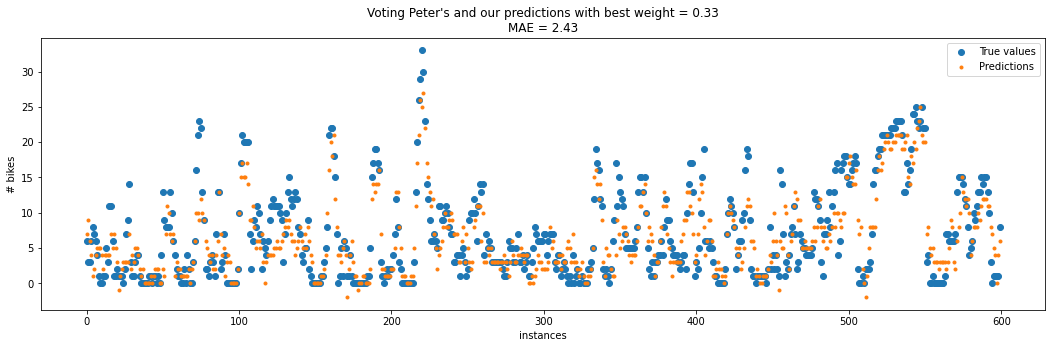

In [17]:
our_weigth = best_weigth2

full_full_preds = combine_with_peters(per_station_preds, our_weigth)

resulting_preds = np.rint(get_voting_preds(full_full_preds))

plot_results(resulting_preds, "Voting Peter's and our predictions with best weight = "+str(np.round(our_weigth,2)))

The table below summarizes the improvement in MAE score when combining predictions from the 200 provided models and our custom-built ones. Note that for the table below, our models were restricted to linear regression with Ridge regularization (as illustrated in our very first notebook). Also noticing that our per-station models outperformed our all-station model, we've only considered the former in this comparison. 

|       | Our models | Given models  | Combined model  |
| :---        |    :----:   |          :---: |          :---: |
| **Averaging**      |   2.47     |2.49| 2.42|
| **Voting**   |    2.47    |2.47| 2.43|


# New predictions for the competition

Now that we know the optimal weights for combining our model with the given models, we can make new predictions for the competition.

In [18]:
X_test = np.load(ASSETS_DIR+'/X_test.npy')
intercept = np.ones((len(X_test)))[:, np.newaxis]
X_test_intercept = np.concatenate([intercept, X_test], axis=1)

ids = np.load(ASSETS_DIR+'/ids_test.npy')

station_ids = np.load(ASSETS_DIR+'/stations_test.npy')

In [19]:
## Our predictions
our_test_preds = np.zeros((len(X_test)))
for i in range(len(X_test)):
    station_id = station_ids[i]
    our_test_preds[i] = per_station_models[station_id].predict([X_test[i]])
our_test_preds = np.rint(our_test_preds)
    
## Peter's predictions
peters_full_test_preds = np.zeros((len(X_test), 200))
for model_id in range(1, 201):
    model = pd.read_csv(make_model_path(model_id))
    preds = predict_with_peters_model(model, X_test_intercept)
    peters_full_test_preds[:, model_id-1] = preds
peters_full_test_preds = np.rint(peters_full_test_preds)
    
# Combine both
our_weight = best_weigth1
dup_count = int(200*our_weight / (1-our_weight))
our_weighted_preds = np.tile(our_test_preds[:, np.newaxis], reps=(1, dup_count))
full_full_preds = np.concatenate([peters_full_test_preds, our_weighted_preds], axis=1)

## Get average/voting prediction
final_test_preds = np.rint(np.mean(full_full_preds, axis=1))
# final_test_preds = np.rint(get_voting_preds(full_full_preds))

## Replace negative predictions with 0
final_test_preds = np.where(final_test_preds<0, np.zeros_like(final_test_preds), final_test_preds)

In [20]:
results = pd.DataFrame({'Id':ids, 'bikes':final_test_preds})
results.to_csv('/kaggle/working/roussel_subin_submission.csv', index=False)
results

,Id,bikes
0,1,1.0
1,2,2.0
2,3,8.0
3,4,4.0
4,5,2.0
...,...,...
2245,2246,11.0
2246,2247,12.0
2247,2248,8.0
2248,2249,13.0
